In [1]:
import psi4
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set Psi4 memory
psi4.set_memory("4 GiB")


  Memory set to   4.000 GiB by Python driver.


4294967296

In [3]:
# Geometry specification
mol = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
symmetry c1
""")

basis = "pcseg-1"

# Psi4 options
psi4.set_options(
    {
        "basis": basis,
        "scf_type": "df",
        "e_convergence": 1e-10,
        "d_convergence": 1e-10,
        "guess": "SAD",
    }
)

wfn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option("basis"))

guess_wfn = psi4.driver.scf_wavefunction_factory(
    name="hf", ref_wfn=wfn, reference="RHF"
)
guess_wfn.form_H()
guess_wfn.form_Shalf()
guess_wfn.guess()
D_guess = guess_wfn.Da()

scf_e, scf_wfn = psi4.energy("scf", return_wfn=True)
D_pq = scf_wfn.Da()


   => Loading Basis Set <=

    Name: PCSEG-1
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   132 file /home/etschgi1/miniconda3/envs/scf_dev/share/psi4/basis/pcseg-1.gbs 
    atoms 2-3 entry H          line    13 file /home/etschgi1/miniconda3/envs/scf_dev/share/psi4/basis/pcseg-1.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,   4096 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

Text(0.5, 1.0, 'Converged density')

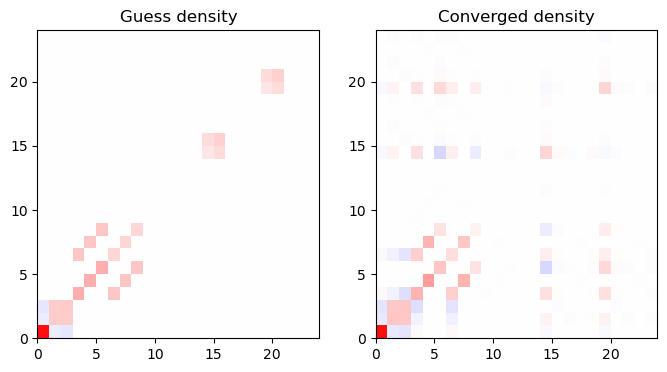

In [4]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2)

ax[0].pcolormesh(D_guess, cmap="bwr", vmin=-1.1, vmax=1.1)
ax[0].set_title("Guess density")
ax[1].pcolormesh(D_pq, cmap="bwr", vmin=-1.1, vmax=1.1)
ax[1].set_title("Converged density")

In [5]:
full_basis = wfn.basisset()
# build the density fitting (df) basis set
df_basis = psi4.core.BasisSet.build(mol, "DF_BASIS_SCF", "", "JKFIT", basis)
# psi4 handles 2 and 3 center ERIs by using the 4 center function and passing the following "empty" basis:
zero_basis = psi4.core.BasisSet.zero_ao_basis_set()

# Build MintsHelper Instance
mints = psi4.core.MintsHelper(full_basis)

# the excess dimensions corresponding to the zero basis are removed using the numpy squeeze method
# (this also converts this obejcts into ndarrays)
# HOTE: this is a bit annoying my version of psi4... We would like to calculate the 3 center ERIs (pq|t) as:
# b_pq_t = np.squeeze(mints.ao_eri(full_basis, full_basis, df_basis, zero_basis))
# However, for some reason this crashes the psi4 kernel. Instead we calculate the transpose:
b_t_pq = np.squeeze(mints.ao_eri(df_basis, zero_basis, full_basis, full_basis))
# the 2 center ERIs V_tu
V_tu = np.squeeze(mints.ao_eri(df_basis, zero_basis, df_basis, zero_basis))
# Invert the Coulomb integral
Vinv_tu = np.linalg.pinv(V_tu)

# Formula (5a)
C_pq_u = np.einsum("tpq,tu->pqu", b_t_pq, Vinv_tu)

   => Loading Basis Set <=

    Name: (PCSEG-1 AUX)
    Role: JKFIT
    Keyword: DF_BASIS_SCF
    atoms 1   entry O          line   318 file /home/etschgi1/miniconda3/envs/scf_dev/share/psi4/basis/def2-universal-jkfit.gbs 
    atoms 2-3 entry H          line    18 file /home/etschgi1/miniconda3/envs/scf_dev/share/psi4/basis/def2-universal-jkfit.gbs 



In [6]:
# Formula (2)
d_u = np.einsum("pqu,pq->u", C_pq_u, D_pq)
# Same for the guess density
d_guess = np.einsum("pqu,pq->u", C_pq_u, D_guess)

In [7]:
# I do not have a good idea of how to plot these vectors, my first try here is by "shell":
def df_vector_to_matrix(d):
    result = np.empty([df_basis.nshell(), df_basis.max_function_per_shell()])
    result.fill(np.nan)

    for n in range(df_basis.nshell()):
        start_ind = df_basis.shell_to_basis_function(n)
        end_ind = df_basis.shell_to_basis_function(n + 1)
        if end_ind == 0:
            end_ind = df_basis.nbf() + 1
        shell_coefficients = d[start_ind:end_ind]
        result[n, 0 : len(shell_coefficients)] = shell_coefficients
    return result

In [8]:
from matplotlib.cm import seismic
from matplotlib.colors import SymLogNorm

# Create custom cmap than assigns gray values to nan
cmap = seismic
cmap.set_bad("0.7", 1.0)

# Since the vectors are dominated by a few large entries we use
# a log norm for the colorbar
norm = SymLogNorm(vmin=-10, vmax=10, linthresh=1e-3, linscale=0.3)

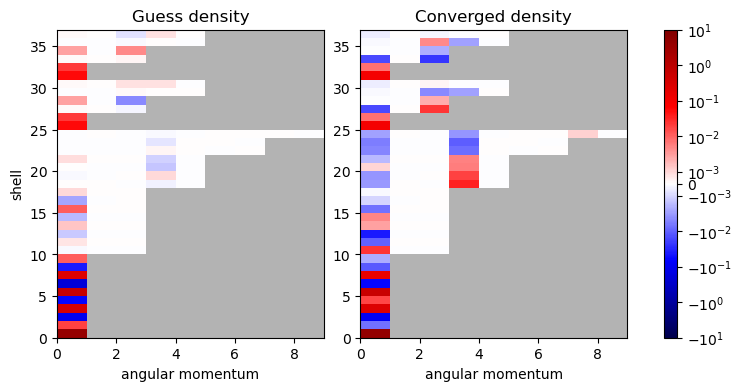

In [9]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=3, width_ratios=[1, 1, 0.05])

ax[0].pcolormesh(df_vector_to_matrix(d_guess), cmap=cmap, norm=norm)
ax[0].set_title("Guess density")

p = ax[1].pcolormesh(df_vector_to_matrix(d_u), cmap=cmap, norm=norm)
ax[1].set_title("Converged density")

ax[0].set_xlabel("angular momentum")
ax[1].set_xlabel("angular momentum")
ax[0].set_ylabel("shell")
plt.colorbar(p, cax=ax[2])